This script was used to produce the results in Fig 3C - where we combine structural analysis (general interafce from predicted monomers using ScanNet and mimicry interface from predicted protein complex strctures and based on CSU analysis) with evolutionary rates.  
As "general interface" residues we take all protein resdiues with a ScanNet scre 0f 0.7 or higher.

# imports, paths, functions

In [1]:
import os
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [4]:
from statsmodels.stats.multitest import multipletests

In [5]:
import itertools

In [72]:
# directory of the current script
script_dir = os.getcwd()

In [84]:
# protein residues tables with CSU analysis results combined with dnds data
path_dnds_csu_mimicked = os.path.join(script_dir, 'mimicry_general_interface_data', 'mimicked_unique_CSU_dnds.csv')
path_dnds_csu_target = os.path.join(script_dir, 'mimicry_general_interface_data', 'target_unique_CSU_dnds.csv')

# scannet tables with residues that scores 0.7 or higher
path_scannet_mimicked = os.path.join(script_dir, 'mimicry_general_interface_data', 'scannet_mimicked_0.7.csv')
path_scannet_target = os.path.join(script_dir, 'mimicry_general_interface_data', 'scannet_target_0.7.csv')


In [18]:
# the path to the folder with scannet csv files 
scannet_folder =  os.path.join(script_dir, 'mimicry_general_interface_data', 'scannet_data')

In [20]:
def get_stats(grouped_df_dict, less_greater):
    dict_keys = list(grouped_df_dict.keys())

    for i in range(0, len(dict_keys), 2):
        if i + 1 < len(dict_keys):  # ensure there is a pair
            key1 = dict_keys[i]
            key2 = dict_keys[i + 1]
            
            list1 = grouped_df_dict[key1]
            list2 = grouped_df_dict[key2]

            stat_PPIs, p_value_PPI = stats.mannwhitneyu(x= list1 , y= list2 , alternative = less_greater)

            # format the resuls as a string
            result = f"p-value of {str(key1)} and {str(key2)} = {p_value_PPI:.2e}"

            # print the results
            print(result)
                        

# get mimicry interface dnds tables

In [86]:
# mimicked proteins interface table

mimicked_df = pd.read_csv(path_dnds_csu_mimicked)
mimicked_I_df = mimicked_df[mimicked_df['csu_result'] == "I"]

In [88]:
# mutual targets proteins interface table

target_df = pd.read_csv(path_dnds_csu_target)
target_I_df = target_df[target_df['csu_result'] == "I"]

In [90]:
csu_I_df = pd.concat([mimicked_I_df, target_I_df ]).reset_index(drop=True)

In [92]:
csu_I_df.rename(columns={'dN/dS':'dnds',}, inplace = True)

In [94]:
csu_I_df['uniprot_index'] = csu_I_df['uniprot_index'].astype(int)

In [152]:
csu_I_df['Class'] = 'AFM_CSU'

In [150]:
csu_uniprots_list = csu_I_df['uniprot'].unique().tolist()

# ScanNet tables

In [101]:
mimicked_scannet_df = pd.read_csv(path_scannet_mimicked)
target_scannet_df = pd.read_csv(path_scannet_target)

In [103]:
mimicked_scannet_df = mimicked_scannet_df[['uniprot','type','Residue Index','Sequence','Binding site probability']]
target_scannet_df = target_scannet_df[['uniprot','type','Residue Index','Sequence','Binding site probability']]

In [105]:
# one full tables with both mimicked and target

scannet_df = pd.concat([mimicked_scannet_df, target_scannet_df], ignore_index=True).drop_duplicates()          

In [107]:
scannet_df

,uniprot,type,Residue Index,Sequence,Binding site probability
0,uniprot,mimicked,12,L,0.724
1,uniprot,mimicked,136,E,0.726
2,uniprot,mimicked,140,W,0.730
3,uniprot,mimicked,179,Y,0.768
4,uniprot,mimicked,183,Y,0.813
...,...,...,...,...,...
1651,P08238,target,687,G,0.921
1652,P08238,target,688,L,0.930
1653,P08238,target,690,I,0.875
1654,P08238,target,695,V,0.826


In [109]:
scannet_df['Residue Index'] = scannet_df['Residue Index'].astype('int')

In [111]:
scannet_df.rename({'Sequence':'res'},axis =1, inplace =True)

# dnds 

## full dnds table

In [113]:
all_dnds_df = pd.concat([mimicked_df,target_df]).reset_index(drop=True)

In [115]:
all_dnds_df.head()

,uniprot,type,uniprot_index,uniprot_seq,csu_result,dN/dS,Uniprot_ResIndex,protein_count,Uniprot_ResIndex_count
0,O00254,mimicked,1,M,S,0.14,O00254_1,1,O00254_1_A
1,O00254,mimicked,2,K,S,0.19,O00254_2,1,O00254_2_A
2,O00254,mimicked,3,A,S,0.31,O00254_3,1,O00254_3_A
3,O00254,mimicked,4,L,S,0.30,O00254_4,1,O00254_4_A
4,O00254,mimicked,5,I,S,0.42,O00254_5,1,O00254_5_A


In [117]:
all_dnds_df['dN/dS'] = all_dnds_df['dN/dS'].astype(float)
all_dnds_df['uniprot_index'] = all_dnds_df['uniprot_index'].astype(int)

## dnds dictionary

In [119]:
# create a dictionary with tuple keys for direct lookup
dnds_dict = all_dnds_df.set_index(['uniprot', 'uniprot_seq', 'uniprot_index'])['dN/dS'].to_dict()

def get_dnds(uniprot, res, res_num):
    return dnds_dict.get((uniprot, res, res_num), np.nan)

# add dnds values to scannet interface residues

In [122]:
scannet_df['dnds'] = scannet_df.apply(
    lambda row: get_dnds(row['uniprot'], row['res'], row['Residue Index']), axis=1)

In [124]:
scannet_df.rename(columns={'Residue Index':'uniprot_index','res':'uniprot_seq'}, inplace = True)


In [126]:
scannet_df['uniprot_index'] = scannet_df['uniprot_index'].astype(int)


In [128]:
# label these rows as scannet rows
scannet_df['Class'] = 'scannet'

In [130]:
scannet_df.head()

,uniprot,type,uniprot_index,uniprot_seq,Binding site probability,dnds,Class
0,uniprot,mimicked,12,L,0.724,NaN,scannet
1,uniprot,mimicked,136,E,0.726,NaN,scannet
2,uniprot,mimicked,140,W,0.730,NaN,scannet
3,uniprot,mimicked,179,Y,0.768,NaN,scannet
4,uniprot,mimicked,183,Y,0.813,NaN,scannet


# combine both tables

In [164]:
combined_df = pd.concat([csu_I_df, scannet_df]).reset_index(drop=True)

In [166]:
combined_df['Class'].value_counts()

Class
AFM_CSU    2141
scannet    1656
Name: count, dtype: int64

In [167]:
combined_df['dnds'] = combined_df['dnds'].astype(float)

In [172]:
combined_df_ = combined_df[['uniprot','type','uniprot_index' , 'uniprot_seq' , 'Class', 'dnds' ]]

In [174]:
combined_plot_df = combined_df.dropna(subset=['dnds'])

# plot

In [189]:
combined_plot_df['Class'] = combined_plot_df ['Class'].replace({'AFM_CSU': 'mimic interface' ,  'scannet': 'general interface'})

palette_dict = {
    'mimicked': ['#a58ce6', '#dad1f0'],  
    'target': ['#6097f0', '#c9d4f2'], 
}

C:\Users\TzachiHNB13\AppData\Local\Temp\ipykernel_95780\3689310015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_plot_df['Class'] = combined_plot_df ['Class'].replace({'AFM_CSU': 'mimic interface' ,  'scannet': 'general interface'})


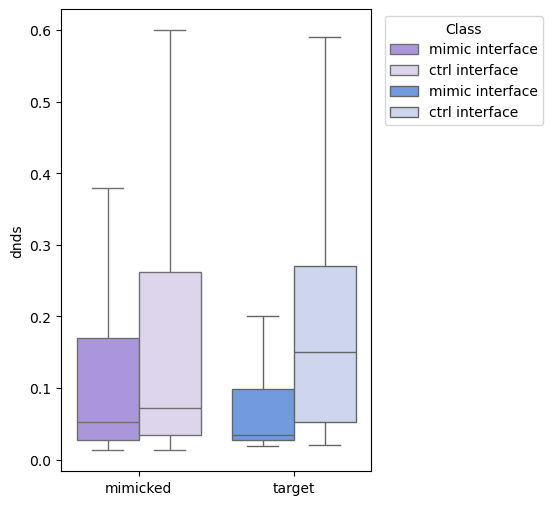

In [191]:
fig, ax = plt.subplots(figsize=(4, 6))

# iterate over unique x categories
for i, x_value in enumerate(combined_plot_df['type'].unique()):
    subset =combined_plot_df[combined_plot_df['type'] == x_value]
    
    sns.boxplot(
        data=subset,
        x=[i] * len(subset),  # Assign a numerical position to each category
        y='dnds',
        hue='Class',
        palette=palette_dict.get(x_value, ['gray', 'black']),  # Default colors if missing
        ax=ax,
        showfliers=False,
    )

# adjust x-axis labels to match original 'type' values
ax.set_xticks(range(len(combined_plot_df['type'].unique())))
ax.set_xticklabels(combined_plot_df['type'].unique())

plt.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left' )


plt.show()

# stats

## mannwhitney

In [195]:
grouped_seven_dict = combined_plot_df.groupby(['type', 'Class'])['dnds'].apply(list).to_dict()

In [197]:
grouped_seven_dict.keys()

dict_keys([('mimicked', 'ctrl interface'), ('mimicked', 'mimic interface'), ('target', 'ctrl interface'), ('target', 'mimic interface')])

In [202]:
get_stats(grouped_seven_dict, "greater")

p-value of ('mimicked', 'ctrl interface') and ('mimicked', 'mimic interface') = 2.77e-09
p-value of ('target', 'ctrl interface') and ('target', 'mimic interface') = 3.39e-43


## FDR correction

In [205]:
rejected, pvals_corrected, _, _ = multipletests([2.77e-09 , 3.39e-43], alpha=0.05, method='fdr_bh')
pvals_corrected

array([2.77e-09, 6.78e-43])